In [ ]:
# Modified from https://github.com/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb

# Try UnSAMv2 on interactive image Segmentation at any granularity!

## Set-up

In [ ]:
import os
import logging
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [ ]:
np.random.seed(94704) # :D

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
logging.basicConfig(level=logging.INFO)

USE_M2M_REFINEMENT = True

def apply_m2m_refinement(
    predictor,
    point_coords,
    point_labels,
    granularity,
    logits,
    best_mask_idx,
    use_m2m=True,
):
    """Optionally run a second M2M pass using the best mask's logits."""
    if not use_m2m:
        return None

    logging.info("Applying M2M refinement...")
    try:
        if logits is None:
            raise ValueError("logits must be provided for M2M refinement.")

        low_res_logits = logits[best_mask_idx:best_mask_idx + 1]
        refined_masks, refined_scores, _ = predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=False,
            gra=granularity,
            mask_input=low_res_logits,
        )
        refined_mask = refined_masks[0]
        refined_score = float(refined_scores[0])
        logging.info(f"M2M refinement completed with score: {refined_score:.3f}")
        return refined_mask, refined_score
    except Exception as exc:
        logging.error(f"M2M refinement failed: {exc}, using original mask")
        return None

## Example image

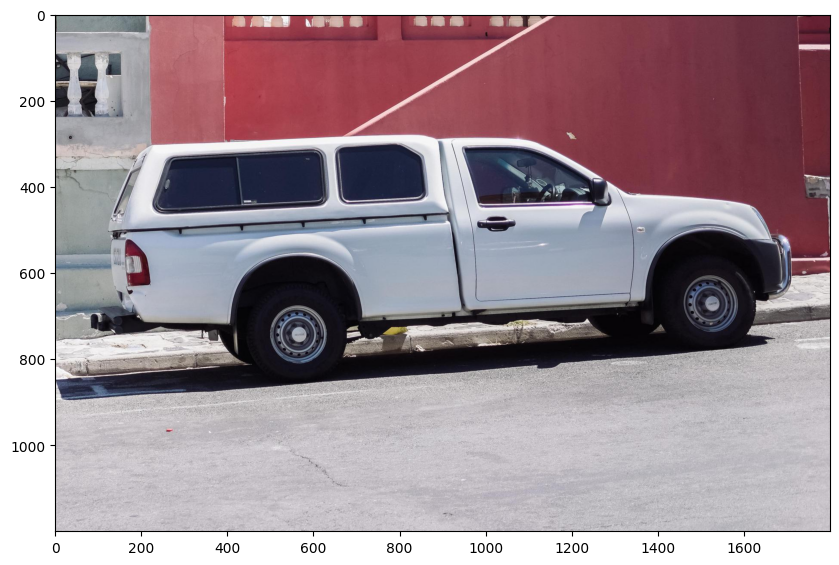

In [39]:
# specify the path here if you want to use your own image
image = Image.open('images/truck.jpg')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM 2

In [30]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/unsamv2_plus_ckpt.pt"
model_cfg = "configs/unsamv2_small.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

Applying LoRA to UnSAMv2...
Successfully applied LoRA to UnSAMv2.


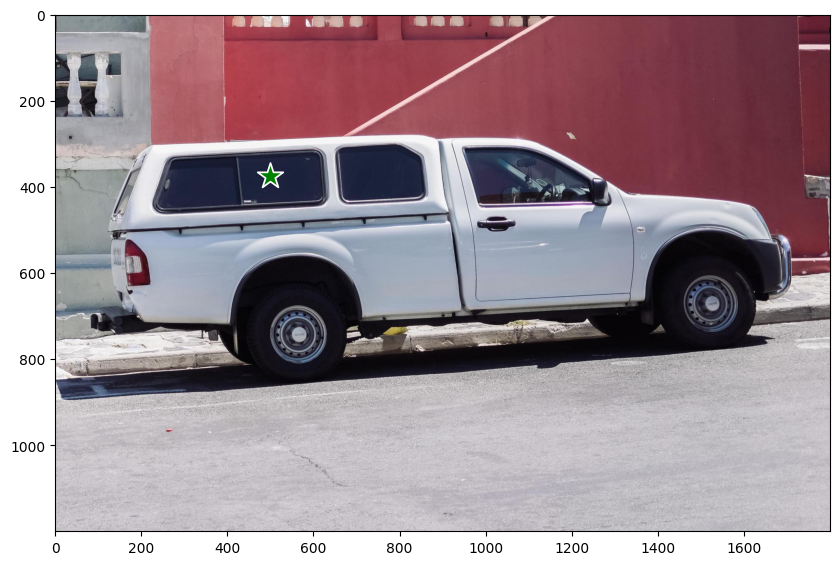

In [32]:
predictor.set_image(image)
input_point = np.array([[500, 375]])
input_label = np.array([1])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [ ]:
# change it to any granularity value in [0.1, 1.0] to see different segmentation results!
granularity = 0.2
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
    gra=granularity,
)
best_mask_idx = int(np.argmax(scores))
best_mask = masks[best_mask_idx]
best_score = float(scores[best_mask_idx])

m2m_result = apply_m2m_refinement(
    predictor=predictor,
    point_coords=input_point,
    point_labels=input_label,
    granularity=granularity,
    logits=logits,
    best_mask_idx=best_mask_idx,
    use_m2m=USE_M2M_REFINEMENT,
)
if m2m_result is not None:
    refined_mask, refined_score = m2m_result
else:
    refined_mask, refined_score = best_mask, best_score

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

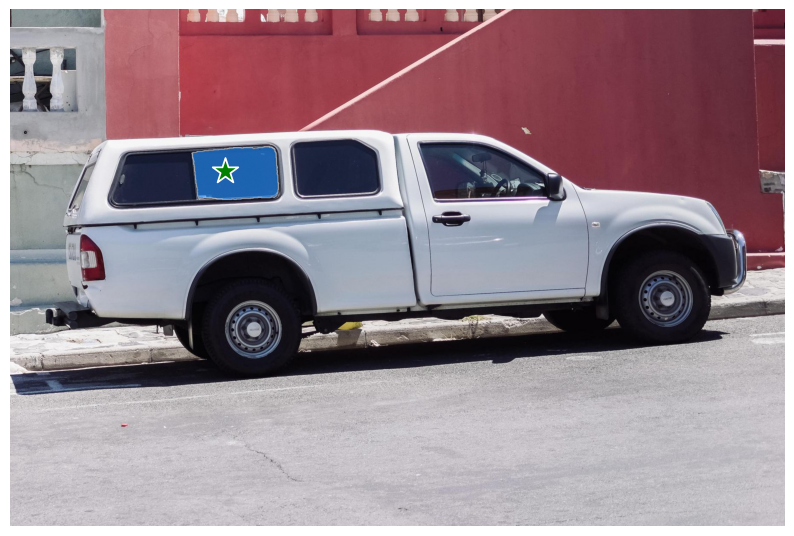

In [38]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)